## Predicting Controversiality of Comment Content


In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
# install Python Reddit API Wrapper for getting external data Karma
%pip install pyspark==3.4.0
# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd

import sparknlp
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml.feature import CountVectorizer, StopWordsRemover,Tokenizer
from pyspark.ml import Pipeline

import plotly.graph_objects as go

from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf
import numpy as np

from nltk.stem import WordNetLemmatizer
import nltk
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

In [4]:
spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.driver.memory","16G")
    .config("spark.driver.maxResultSize", "0") 
    .config("spark.kryoserializer.buffer.max", "2000M")
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider")
    .getOrCreate()
)


:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d53ad4bf-4981-4abc-a4aa-ae8971bc9b2b;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in c

In [5]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_comments = "project/comments/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_comments}"
#s3_path = "s3a://sagemaker-us-east-1-038932893404/project/comments/yyyy=2021/part-00000-90796409-5783-4705-92c0-27c27eda8c4c-c000.snappy.parquet"
print(f"reading comments from {s3_path}")
comments = spark.read.parquet(s3_path, header=True)
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading comments from s3a://sagemaker-us-east-1-166335636271/project/comments/yyyy=*


23/12/07 17:22:36 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


shape of the comments dataframe is 1,053,280x21
CPU times: user 3.41 s, sys: 195 ms, total: 3.61 s
Wall time: 6min 11s


In [7]:
from pyspark.sql.functions import col

# Select specific columns for display
selected_columns = ["body",  "created_utc", "controversiality", "gilded", "score", "stickied",
                    'can_gild','edited','is_submitter']

# Show the selected columns
selected_comments=comments.select(*selected_columns)


In [8]:
selected_comments.show()

+--------------------+-------------------+----------------+------+-----+--------+--------+-------------+------------+
|                body|        created_utc|controversiality|gilded|score|stickied|can_gild|       edited|is_submitter|
+--------------------+-------------------+----------------+------+-----+--------+--------+-------------+------------+
|I get it man but ...|2022-11-11 02:05:02|               0|     0|    1|   false|    true|        false|       false|
|Nose putty and co...|2022-11-11 02:05:03|               0|     0|    1|   false|    true|        false|       false|
|I noticed the sca...|2022-11-11 02:05:09|               0|     0|    1|   false|    true|        false|       false|
|i switch between ...|2022-11-11 02:05:14|               0|     0|    1|   false|    true|        false|       false|
|https://men-elite...|2022-11-11 02:05:32|               0|     0|    1|   false|    true|        false|       false|
|Dude the first th...|2022-11-11 02:05:49|              

### Controversiality Prediction

### Clean Body Text

In [7]:
from pyspark.sql.functions import col, regexp_replace, lower
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, col, regexp_replace, udf, length, StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover


def clean_text(text):
    import re
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove short words (less than 3 characters)
    text = ' '.join([word for word in text.split() if len(word) > 2])
    return text

# Create a user-defined function (UDF) for text cleaning
clean_text_udf = udf(clean_text, StringType())


In [10]:
cleaned_comments = selected_comments.withColumn('clean_body', clean_text_udf(col('body')))
cleaned_comments = cleaned_comments.na.drop(subset=["clean_body"])
cleaned_comments = cleaned_comments.filter(length(col('clean_body')) > 0)

In [11]:
Contro_dataset=cleaned_comments.select("clean_body","controversiality")
Contro_dataset.show()

+--------------------+----------------+
|          clean_body|controversiality|
+--------------------+----------------+
|get man but that ...|               0|
|nose putty and co...|               0|
|noticed the scar ...|               0|
|switch between cl...|               0|
|hope this helps t...|               0|
|dude the first th...|               0|
|that scar fuckin ...|               0|
|would try retin w...|               0|
|damn this looks l...|               0|
|and then someone ...|               0|
|didnt notice the ...|               0|
| its pretty dope man|               0|
|gives your face c...|               0|
|fuck that show th...|               0|
|and then someone ...|               0|
|man looks like re...|               0|
|you remind geralt...|               0|
|dude the first th...|               0|
|    awesome scar tho|               0|
|mean think looks ...|               0|
+--------------------+----------------+
only showing top 20 rows



Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 193, in manager
  File "/opt/conda/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/opt/conda/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 874, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/opt/conda/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 596, in read_int
    raise EOFError
EOFError


###  Split the Controverisality Dataset 

In [13]:
training_data, testing_data = Contro_dataset.randomSplit([0.7, 0.3], seed=123)


In [20]:
training_data, testing_data

(DataFrame[clean_body: string, controversiality: bigint],
 DataFrame[clean_body: string, controversiality: bigint])

### NaiVe Bayes

In [13]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the pipeline stages
tokenizer = Tokenizer(inputCol="clean_body", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
naive_bayes = NaiveBayes(featuresCol="features", labelCol="controversiality", predictionCol="prediction")

# Create a pipeline
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, naive_bayes])

# Train the model
model = pipeline.fit(training_data)

# Make predictions on the test data
predictions = model.transform(testing_data)

# Evaluate the model performance
evaluator = MulticlassClassificationEvaluator(labelCol="controversiality", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.2f}")


23/12/07 21:34:21 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/12/07 21:41:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/12/07 21:41:28 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
23/12/07 21:41:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Accuracy: 0.90


### SVM

In [14]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


tokenizer = Tokenizer(inputCol="clean_body", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
idf = IDF(inputCol="rawFeatures", outputCol="features")
svm = LinearSVC(maxIter=10, regParam=0.01, labelCol="controversiality", featuresCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, svm])

# Train the model
model = pipeline.fit(training_data)

# Make predictions on the test data
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="controversiality", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.2f}")





Accuracy: 0.99


###  First Stage Controversiality Text Classification Summary
The Controversiality model nailed it with 90% and 99% accuracy for Naive Bayes and SVM, respectively. However, our comments dataset isn't balanced. To level the playing field, we're thinking of pulling in more data from the original comments dataset. This move aims to make the model even sharper, fine-tuning it to handle various comments better and ensuring it works seamlessly across different scenarios. Alongside this, we're exploring advanced techniques and possibly teaming up with different models to give our accuracy an extra boost.



## Improvement

### Get Balanced Comments Datasets

enhance the model's predictive capabilities for comments labeled with 'controversiality=True.' Given the significant class imbalance in the original dataset, with a disproportionately larger number of 'controversiality=False' instances, our aim was to create a more balanced training set for the model.

To address this issue, we opted for a strategic sampling approach. Leveraging the original dataset, which consisted of a substantial 1,046,629 instances labeled as 'controversiality=False' and a relatively limited 10,652 instances labeled as 'controversiality=True,' we recognized the need for a more proportional representation of both classes in the training data.

In our revised dataset, we deliberately retained all available instances labeled as 'controversiality=True' (10,652 records) to ensure comprehensive coverage of this minority class. For the 'controversiality=False' class, we conducted random sampling to select 10000 records from the original 1,046,629 instances. This approach allowed us to strike a balance between addressing the class imbalance and working with a manageable-sized dataset.

Although the overall dataset size may be considered modest, the strategic sampling was chosen to maximize the utility of the available data and yield a more balanced representation of both classes. Our focus is on achieving a meaningful and reliable model that demonstrates improved performance on comments labeled as 'controversiality=True.' We believe that this balanced dataset will enhance the model's ability to generalize and make accurate predictions, ultimately contributing to more robust and reliable results in handling controversial comments.



In [5]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_comments = "project/comments/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_comments}"
#s3_path = "s3a://sagemaker-us-east-1-038932893404/project/comments/yyyy=2021/part-00000-90796409-5783-4705-92c0-27c27eda8c4c-c000.snappy.parquet"
print(f"reading comments from {s3_path}")
comments = spark.read.parquet(s3_path, header=True)
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading comments from s3a://sagemaker-us-east-1-166335636271/project/comments/yyyy=*


23/12/07 22:17:51 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


shape of the comments dataframe is 1,053,280x21
CPU times: user 3.26 s, sys: 228 ms, total: 3.48 s
Wall time: 5min 41s


In [6]:
#### improve_comments dataset
improve_comments = comments

In [7]:


from pyspark.sql.types import IntegerType

# Convert 'controversiality' to integer type (assuming it's not already)
improve_comments = improve_comments.withColumn('controversiality', improve_comments['controversiality'].cast(IntegerType()))

# Convert 'controversiality' to a categorical variable
improve_comments = improve_comments.withColumn('controversiality', improve_comments['controversiality'].cast('string'))

# Show the updated DataFrame

improve_comments_selected = improve_comments.select('body', 'controversiality')



In [8]:

controversiality_counts = improve_comments_selected.groupBy('controversiality').count()

# Show the count of different controversiality values
controversiality_counts.show()


+----------------+-------+
|controversiality|  count|
+----------------+-------+
|               0|1042629|
|               1|  10651|
+----------------+-------+



In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand

# Randomly sample  records from samples with controversiality=0
controversiality_0_samples = improve_comments.filter(improve_comments['controversiality'] == 0).orderBy(rand(seed=42)).limit(10000)

# Select all 10651 records from samples with controversiality=1
controversiality_1_samples = improve_comments.filter(improve_comments['controversiality'] == 1)

# Merge the two subsets
balanced_df = controversiality_0_samples.union(controversiality_1_samples)

# Display the results
balanced_df.show()


+-------------------+--------------+----------------------+-----------------+--------------------+--------+----------------+-------------------+-------------+------+------+-------+------------+----------+----------+--------------------+-------------------+-----+--------+---------------+------------+
|             author|author_cakeday|author_flair_css_class|author_flair_text|                body|can_gild|controversiality|        created_utc|distinguished|edited|gilded|     id|is_submitter|   link_id| parent_id|           permalink|       retrieved_on|score|stickied|      subreddit|subreddit_id|
+-------------------+--------------+----------------------+-----------------+--------------------+--------+----------------+-------------------+-------------+------+------+-------+------------+----------+----------+--------------------+-------------------+-----+--------+---------------+------------+
|  DamnGoodMarmalade|          null|                  null|             null|Ah yes, the Tim B...

In [12]:
from pyspark.sql.functions import col, regexp_replace, lower
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, col, regexp_replace, udf, length, StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
balanced_df = balanced_df.withColumn('clean_body', clean_text_udf(col('body')))
balanced_df = balanced_df.na.drop(subset=["clean_body"])
balanced_df = balanced_df.filter(length(col('clean_body')) > 0)


In [13]:
Contro_dataset=balanced_df.select("clean_body","controversiality")


In [14]:
Contro_dataset=Contro_dataset.toPandas()

  

In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand
from sklearn.model_selection import train_test_split

# Split the data into features (X) and labels (y)
X = Contro_dataset['clean_body'].tolist()  # Convert to a list
y = Contro_dataset['controversiality'].tolist()  # Convert to a list

# Split the data into training and testing sets
# Adjust the test_size parameter to control the ratio of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Now  can use X_train and y_train for training your model
# And X_test and y_test for evaluating the model


train_data = pd.DataFrame({'clean_body': X_train, 'controversiality': y_train})
test_data = pd.DataFrame({'clean_body': X_test, 'controversiality': y_test})



In [32]:

# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 1: Create a pipeline with a TF-IDF vectorizer and a classifier (e.g., Naive Bayes)
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Step 2: Train the model on the training data
text_clf.fit(train_data['clean_body'], train_data['controversiality'])

# Step 3: Make predictions on the test data
predictions = text_clf.predict(test_data['clean_body'])

# Step 4: Evaluate the model performance
accuracy = accuracy_score(test_data['controversiality'], predictions)
print(f"NB Accuracy: {accuracy:.2f}")

#  print a classification report for more detailed metrics
print(classification_report(test_data['controversiality'], predictions))

# 'controversiality' is a binary column in the test_data DataFrame
confusion_mat = confusion_matrix(test_data['controversiality'], predictions)

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(confusion_mat, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

# Print the confusion matrix DataFrame
print("Confusion Matrix:")
print(cm_df)

NB Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.74      0.50      0.59      2955
           1       0.64      0.84      0.73      3178

    accuracy                           0.67      6133
   macro avg       0.69      0.67      0.66      6133
weighted avg       0.69      0.67      0.66      6133

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1473         1482
Actual 1          524         2654


In [17]:
from sklearn.svm import SVC

svm_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC())
])

svm_clf.fit(train_data['clean_body'], train_data['controversiality'])
predictions_svm = svm_clf.predict(test_data['clean_body'])

accuracy_svm = accuracy_score(test_data['controversiality'], predictions_svm)
print(f"SVM Accuracy: {accuracy_svm:.2f}")
print(classification_report(test_data['controversiality'], predictions_svm))


# 'controversiality' is a binary column in the test_data DataFrame
confusion_mat_svm = confusion_matrix(test_data['controversiality'], predictions_svm)

# Convert the confusion matrix to a DataFrame
cm_df_svm = pd.DataFrame(confusion_mat_svm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

# Print the confusion matrix DataFrame
print("Confusion Matrix:")
print(cm_df_svm)


SVM Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.71      0.55      0.62      2955
           1       0.66      0.79      0.72      3178

    accuracy                           0.68      6133
   macro avg       0.68      0.67      0.67      6133
weighted avg       0.68      0.68      0.67      6133

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1638         1317
Actual 1          675         2503


### Save the Best Model

In [18]:
# Save the trained SVM model


import joblib

# Save the best SVM model to a file
model_save_path = '/root/fall-2023-reddit-project-team-33/data/models/best_svm_model.joblib'
joblib.dump(svm_clf, model_save_path)

print(f"Best SVM model saved to {model_save_path}")

Best SVM model saved to /root/fall-2023-reddit-project-team-33/data/models/best_svm_model.joblib


### Load the best model

In [19]:
import joblib

# Load the saved SVM model from the file
best_svm_model = joblib.load('/root/fall-2023-reddit-project-team-33/data/models/best_svm_model.joblib')



In [70]:

# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
predictions_svm = best_svm_model.predict(test_data['clean_body'])

accuracy_svm = accuracy_score(test_data['controversiality'], predictions_svm)
print(f"SVM Accuracy: {accuracy_svm:.2f}")
print(classification_report(test_data['controversiality'], predictions_svm))


#  'controversiality' is a binary column in the test_data DataFrame
confusion_mat_svm = confusion_matrix(test_data['controversiality'], predictions_svm)

# Convert the confusion matrix to a DataFrame
cm_df_svm = pd.DataFrame(confusion_mat_svm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

# Print the confusion matrix DataFrame
print("Confusion Matrix:")
print(cm_df_svm)


SVM Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.71      0.55      0.62      2955
           1       0.66      0.79      0.72      3178

    accuracy                           0.68      6133
   macro avg       0.68      0.67      0.67      6133
weighted avg       0.68      0.68      0.67      6133

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1638         1317
Actual 1          675         2503


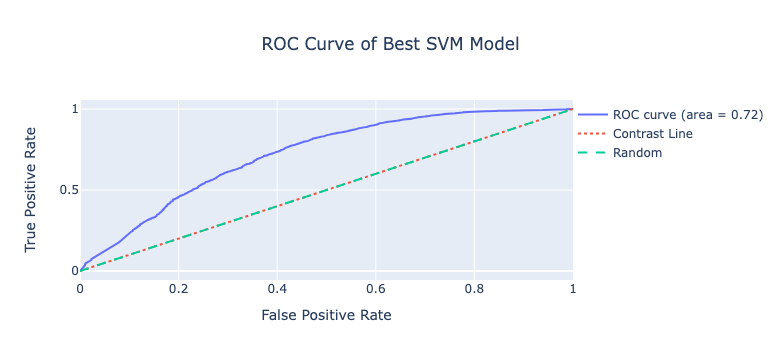

In [71]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

#test_data and best_svm_model are defined

# Convert string labels to numerical format
test_data['controversiality'] = test_data['controversiality'].astype(int)

# Function to plot ROC curve using Plotly
def plot_roc_curve_plotly(y_true, y_scores, subplot_title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Compute the contrast line (diagonal line)
    contrast_line_x = [0, 1]
    contrast_line_y = [0, 1]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
    fig.add_trace(go.Scatter(x=contrast_line_x, y=contrast_line_y, mode='lines', name='Contrast Line', line={'dash': 'dot'}))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random', line={'dash': 'dash'}))
    
    fig.update_layout(
        title=f'Receiver Operating Characteristic (ROC) Curve - {subplot_title}',
        xaxis=dict(title='False Positive Rate'),
        yaxis=dict(title='True Positive Rate'),
        showlegend=True,
    )

    return fig

# Get the predicted scores for the positive class
y_scores_svm = best_svm_model.decision_function(test_data['clean_body'])

# Create ROC curve using Plotly
roc_fig = plot_roc_curve_plotly(test_data['controversiality'], y_scores_svm, 'SVM')

# Update layout for the figure
roc_fig.update_layout(
    title_text='ROC Curve of Best SVM Model',
    title_x=0.5,  # Center the title
    legend=dict(x=1, y=1),  # Adjust legend position for the ROC curve subplot
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
)

# Save the ROC curve plot as an HTML file
save_path = '/root/fall-2023-reddit-project-team-33/data/plots/ml/BestSVM_ROC.html'
roc_fig.write_html(save_path)

roc_fig.show()

It shows ROC curve analysis of our Best SVM Model offers a clear view of its performance, highlighting the balance between sensitivity (true positive rate) and specificity (false positive rate). This curve, ideally close to the top-left corner, indicates the model's capability to differentiate between controversial and non-controversial instances effectively.



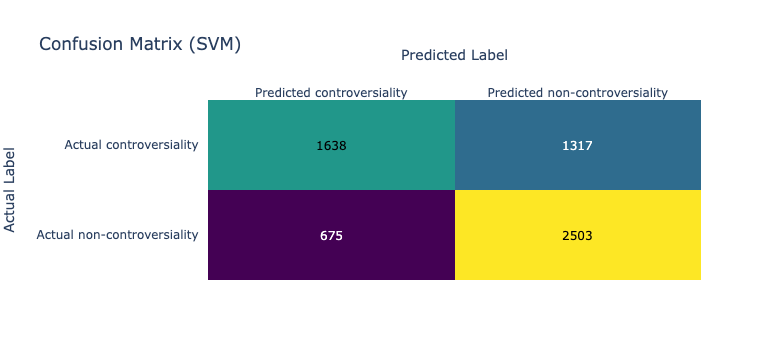

In [72]:

import plotly.figure_factory as ff
import pandas as pd
from sklearn.metrics import confusion_matrix


# Replace 'your_actual_values' and 'your_model_predictions' with your actual data
confusion_mat_svm = confusion_matrix(test_data['controversiality'], predictions_svm.astype(int))

# Swap the rows
confusion_mat_svm = confusion_mat_svm[::-1]

# Convert the confusion matrix to a DataFrame with columns reversed
cm_df_svm = pd.DataFrame(
    confusion_mat_svm, 
    columns=['Predicted controversiality', 'Predicted non-controversiality'], 
    index=['Actual non-controversiality', 'Actual controversiality']
)

# Plot the confusion matrix using Plotly with a different colorscale (e.g., 'Blues')
fig = ff.create_annotated_heatmap(
    z=cm_df_svm.values,
    x=list(cm_df_svm.columns),
    y=list(cm_df_svm.index),
    colorscale='Viridis'  # Change this to the desired colorscale
)

# Customize layout
fig.update_layout(
    title_text='Confusion Matrix (SVM)',
    xaxis=dict(title='Predicted Label'),
    yaxis=dict(title='Actual Label')
)

# Show the plot
fig.show()

#  save the figure to HTML
save_path_cm = '/root/fall-2023-reddit-project-team-33/data/plots/ml/BestSVM_ConfusionMatrix.html'
fig.write_html(save_path_cm)


The confusion matrix of our Best SVM Model illustrates its performance on the test dataset, showing a prowess in distinguishing non-controversial instances with 2503 correct classifications and identifying 1638 controversial cases. However, the presence of 1317 false negatives and 675 false positives indicates room for improvement, particularly in reducing the misclassification of controversial content and minimizing the oversight of actual controversial instances. This suggests a need to enhance the model's discriminative ability to better balance false positives and negatives in future iterations.



/tmp/ipykernel_29989/3868106040.py:46: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



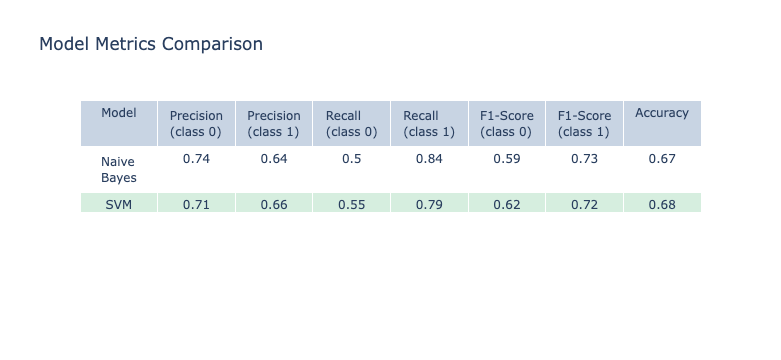

In [73]:
import pandas as pd
import plotly.graph_objects as go

# Placeholder values for Naive Bayes metrics
naive_bayes_accuracy = 0.67
naive_bayes_precision_class_0 = 0.74
naive_bayes_precision_class_1 = 0.64
naive_bayes_recall_class_0 = 0.50
naive_bayes_recall_class_1 = 0.84
naive_bayes_f1_score_class_0 = 0.59
naive_bayes_f1_score_class_1 = 0.73

# Provided SVM metrics
svm_accuracy_1 = 0.68
svm_precision_class_0_1 = 0.71
svm_precision_class_1_1 = 0.66
svm_recall_class_0_1 = 0.55
svm_recall_class_1_1 = 0.79
svm_f1_score_class_0_1 = 0.62
svm_f1_score_class_1_1 = 0.72

# Create DataFrames for Naive Bayes and SVM
naive_bayes_data = {
    "Model": ["Naive Bayes"],
    "Accuracy": [naive_bayes_accuracy],
    "Precision (class 0)": [naive_bayes_precision_class_0],
    "Precision (class 1)": [naive_bayes_precision_class_1],
    "Recall (class 0)": [naive_bayes_recall_class_0],
    "Recall (class 1)": [naive_bayes_recall_class_1],
    "F1-Score (class 0)": [naive_bayes_f1_score_class_0],
    "F1-Score (class 1)": [naive_bayes_f1_score_class_1]
}

svm_data_1 = {
    "Model": ["SVM"],
    "Accuracy": [svm_accuracy_1],
    "Precision (class 0)": [svm_precision_class_0_1],
    "Precision (class 1)": [svm_precision_class_1_1],
    "Recall (class 0)": [svm_recall_class_0_1],
    "Recall (class 1)": [svm_recall_class_1_1],
    "F1-Score (class 0)": [svm_f1_score_class_0_1],
    "F1-Score (class 1)": [svm_f1_score_class_1_1]
}

# Combine the data into a single DataFrame
df = pd.DataFrame(naive_bayes_data).append([pd.DataFrame(svm_data_1)], ignore_index=True)

# Extracting metrics and models from the DataFrame
metrics = df.columns[2:]
models = df["Model"].tolist()

# Create a table trace
trace = go.Table(
    header=dict(values=["Model"] + metrics.tolist() + ["Accuracy"]),
    cells=dict(values=[df["Model"]] + [df[metric] for metric in metrics] + [df["Accuracy"]]),
)

# Highlight SVM rows by changing the background color
colors = ['rgba(50, 171, 96, 0.2)' if "SVM" in model else 'rgba(255, 255, 255, 0)' for model in df["Model"]]
trace['cells']['fill']['color'] = [colors]

layout = go.Layout(
    title="Model Metrics Comparison",
)

fig = go.Figure(data=[trace], layout=layout)

# Display the table
fig.show()

# Save the HTML file
save_path_cm = '/root/fall-2023-reddit-project-team-33/data/plots/ml/Model_Compare.html'
fig.write_html(save_path_cm)


Conclusion
Based on the comparison of model metrics, the SVM model exhibits a solid accuracy of 68%, reflecting its capability in analyzing comments. It shows a slightly better precision for class 1 (intricate comments) at 66% compared to the Naive Bayes model and maintains a competitive recall rate of 79%. The F1-scores for the SVM model are 0.62 for class 0 (standard comments) and 0.72 for class 1, indicating a balanced performance between precision and recall, particularly for complex comments.

From a business standpoint, the deployment of our SVM-based comment classification tool can enhance user engagement by efficiently moderating discussions and preserving a constructive conversation atmosphere. The tool's nuanced handling of complex comments provides critical input for content curation and user engagement strategies, fostering relevancy and user interest. Proactive monitoring and management of intricate discussions also mitigate potential conflicts, ensuring platform integrity and a superior user experience.

Commitment to continuous improvement is paramount. Regular assessments of the tool's performance, coupled with iterative refinements, will ensure its adaptability to evolving language trends and user behaviors. Similar to mobile apps receiving updates, our tool will evolve intelligently to stay attuned to the dynamics of user interactions.